# __An Analysis on The Reliability of The COMPAS Recidivism Algorithm__

<center>
    <i>Ahmad Said, Yiyuan Cui, Berry Ma, Elavarthi Pragna, Muhammad Fadli Alim Arsani</i> 
</center>

In this project, we analyse the reliability of an algorithm used to predict the tendency of a convicted criminal to reoffend. In particular, __we argue that the COMPAS Recidivism Algorithm is biased towards certain races, specifically African-American__.

This notebook showcase our attempts on strengthening our claim using data analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 25, 10

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("compas-scores-two-years.csv")

## Muhammad Fadli

Here, we take a look at how `decile_score` (1-10, 10 being most likelike to recid) is related to `sex`, `age_cat` (age categories), and `race`. The x-axis is is the decile scores and the y-axis is the count of how many of the criminals correspond to that decile score.

We see that all 3 shows a trend, however, what we're interested in is the trend shown by the `race` feature since it is uncanny - African-American race is highly rated as being more likely to recid than other race. As the decile score increase, there is a significant difference in the count between the races.

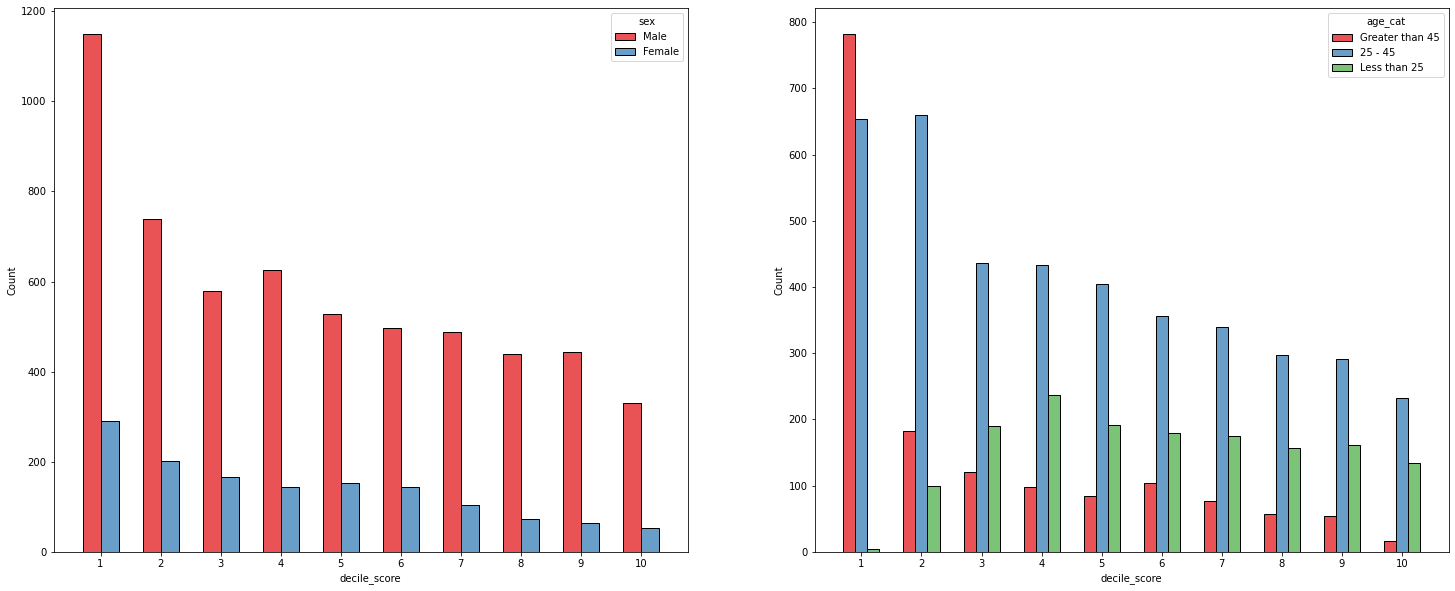

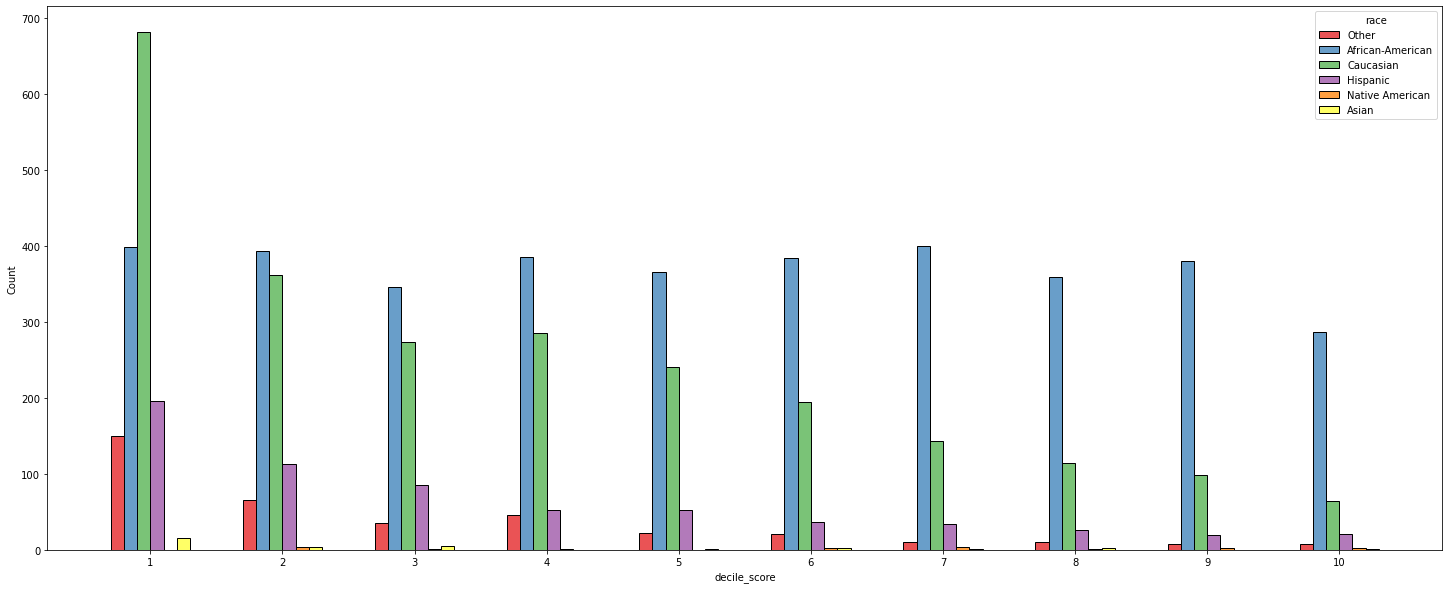

In [2]:
plt.subplot(121)
sns.histplot(data=df, palette=sns.color_palette("Set1", 2), shrink=.6, x='decile_score', hue='sex', multiple='dodge', discrete=True)
plt.xticks(list(range(1, 11)), list(range(1, 11)))

plt.subplot(122)
sns.histplot(data=df, palette=sns.color_palette("Set1", 3), shrink=.6, x='decile_score', hue='age_cat', multiple='dodge', discrete=True)
plt.xticks(list(range(1, 11)), list(range(1, 11)))

plt.show()

sns.histplot(data=df, palette=sns.color_palette("Set1", 6), shrink=.6, x='decile_score', hue='race', multiple='dodge', discrete=True)
plt.xticks(list(range(1, 11)), list(range(1, 11)))

plt.show()

## Yiyuan

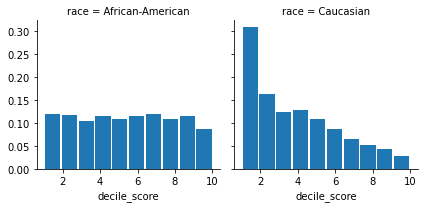

In [3]:
RACE_IN_FOCUS = ['African-American', 'Caucasian']
df_race_focused = df[df['race'].isin(RACE_IN_FOCUS)]
g = sns.FacetGrid(df_race_focused, col='race')
g.map(plt.hist, 'decile_score', rwidth=0.9,density = True)

In [4]:
pd.crosstab(df_race_focused['decile_score'], df['race'], normalize = 'columns')

race,African-American,Caucasian
decile_score,,
1,0.107684,0.277506
2,0.106331,0.147107
3,0.093615,0.111247
4,0.104167,0.116137
5,0.098755,0.098207
6,0.103896,0.079055
7,0.108225,0.058272
8,0.097132,0.046455
9,0.102814,0.039935


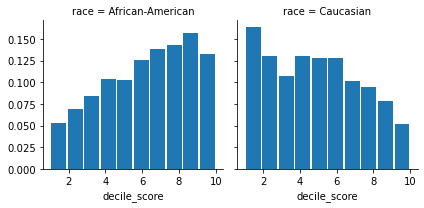

In [5]:
recid_df = df.loc[df['two_year_recid']==1]
recid_df_race_focused = recid_df[recid_df['race'].isin(RACE_IN_FOCUS)]
g = sns.FacetGrid(recid_df_race_focused, col='race')
g.map(plt.hist, 'decile_score', rwidth=0.9, density = True)

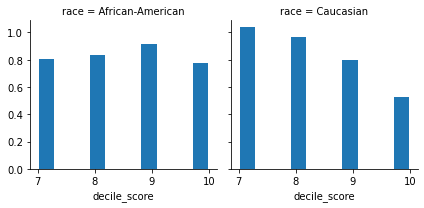

In [6]:
high_decile_recide = recid_df.loc[recid_df['decile_score'] > 6]
focused_high_decile = high_decile_recide[high_decile_recide['race'].isin(RACE_IN_FOCUS)]
g = sns.FacetGrid(focused_high_decile, col='race')
g.map(plt.hist, 'decile_score', rwidth=0.9,density = True)

In [7]:
df = df.fillna(0)
df = df.replace({'race' : { 'African-American' : 0, 'Asian' : 1, 'Caucasian' : 3 ,'Hispanic':4,'Native American':5,'Other':6}})
df = df.replace({'sex' : { 'Male' : 1, 'Female' : 0}})

corr_df = pd.DataFrame(columns=['r','p'])
for col in df:
    if pd.api.types.is_numeric_dtype(df[col]):
        r,p = stats.pearsonr(df.two_year_recid,df[col])
        corr_df.loc[col] = [round(r,3),round(p,3)]

cor_value = abs(corr_df.r).sort_values(ascending=False)
cor_value.head(20)

two_year_recid             1.000
is_recid                   0.941
event                      0.786
end                        0.771
is_violent_recid           0.356
decile_score               0.351
decile_score.1             0.351
v_decile_score             0.296
priors_count               0.275
priors_count.1             0.275
age                        0.190
r_days_from_arrest         0.161
race                       0.127
juv_misd_count             0.109
juv_other_count            0.108
juv_fel_count              0.093
sex                        0.092
start                      0.080
c_days_from_compas         0.068
days_b_screening_arrest    0.025
Name: r, dtype: float64

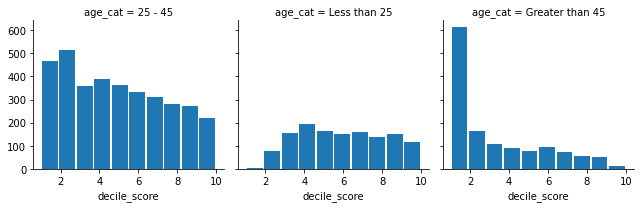

In [8]:
g = sns.FacetGrid(df_race_focused, col='age_cat')
g.map(plt.hist, 'decile_score', rwidth=0.9)

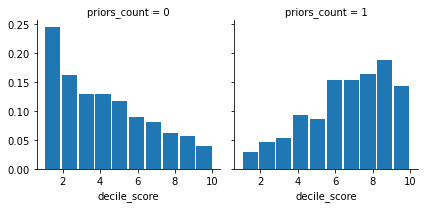

In [9]:
import numpy as np
df_race_focused["priors_count"] = np.where(df_race_focused["priors_count"] <= 5, 0, 1)
g = sns.FacetGrid(df_race_focused, col='priors_count')
g.map(plt.hist, 'decile_score', rwidth=0.9,density = True)

## Berry

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
df = pd.read_csv("compas-scores-two-years.csv")
rcParams['figure.figsize'] = 5, 5

We try to use the dataset itself to do some prediction. By adding a new column, we can translate the risk score (decile_score) into a binary label.\
A score of 5 or higher (Medium or High risk) suggests that one is more likely to be a recividist, and a score of 4 or lower (Low risk) means one is unlikely to re-offend.

In [11]:
df['is_med_or_high_risk']  = (df['decile_score']>=5).astype(int)

To evaluate the prediction, we will compare the predictions to the “truth”

In [12]:
# classification results
np.mean(df['is_med_or_high_risk']==df['two_year_recid'])
np.mean(df['two_year_recid'])

0.6537288605489326

0.45065151095092876

This looks problematic.
There are two kinds of errors in the prediction.

+ false positives (predicted as medium/high risk but does not re-offend)
+ false negatives (predicted as low risk, but does re-offend)

By creating a confusion matrix, we can pull them out separately, to see different types of errors.

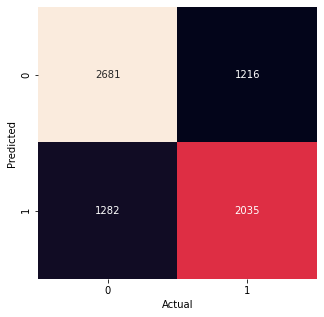

In [13]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'])
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)

In [14]:
[[tn , fp],[fn , tp]]  = confusion_matrix(df['two_year_recid'], df['is_med_or_high_risk'])
print("True negatives:  ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives:  ", tp)

True negatives:   2681
False positives:  1282
False negatives:  1216
True positives:   2035


normalize by row

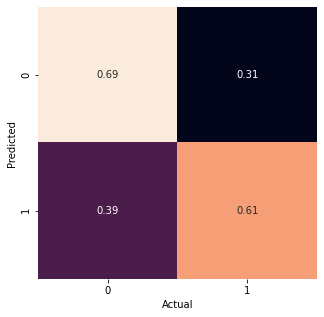

In [15]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='index')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

normalize by column

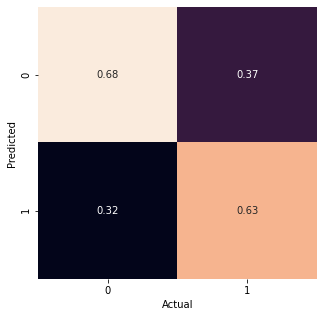

In [16]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

We see that a defendant has a similar likelihood of being wrongly labeled a likely recidivist and of being wrongly labeled as unlikely to re-offend.

In [17]:
fpr = fp/(fp+tn)
fnr  = fn/(fn+tp)
 
 
print("False positive rate (overall): ", fpr)
print("False negative rate (overall): ", fnr)

False positive rate (overall):  0.32349230381024474
False negative rate (overall):  0.3740387573054445


We could also explore the relation between risk score and recidivism.

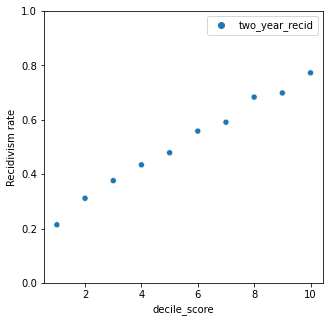

In [18]:
d = df.groupby('decile_score').agg({'two_year_recid': 'mean'})
sns.scatterplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate');

Receiver Operating Characteristic curve(ROC curve) and Area Under the Curve(AUC) are often used to evaluate a binary classifier.\
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.\
The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

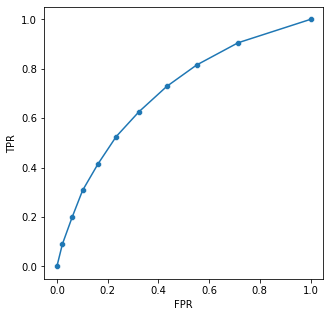

In [19]:
fpr, tpr, thresholds = roc_curve(df['two_year_recid'], df['decile_score'])
sns.scatterplot(x=fpr, y=tpr, );
sns.lineplot(x=fpr, y=tpr);
plt.ylabel("TPR");
plt.xlabel("FPR");


In [20]:
auc = roc_auc_score(df['two_year_recid'], df['decile_score'])
auc

0.7021662544019724

We find out how frequently each race is represented in the data

In [21]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

We focus specifically on African-American or Caucasian.\
We calculate the prediction accuracy like we did above to these two groups.

In [22]:
df = df[df.race.isin(["African-American","Caucasian"])]
# compare accuracy
(df['two_year_recid']==df['is_med_or_high_risk']).astype(int).groupby(df['race']).mean()

race
African-American    0.638258
Caucasian           0.669927
dtype: float64

Now let’s see whether a defendant classified as medium/high risk has the same probability of recidivism for the two groups.\
In other words, we calculate the Positive Predictive Value (PPV).

In [23]:
#PPV
df[df['is_med_or_high_risk']==1]['two_year_recid'].groupby(df['race']).mean()

race
African-American    0.629715
Caucasian           0.591335
Name: two_year_recid, dtype: float64

Now we check whether a defendant with a given score has the same probability of recidivism for the two groups.

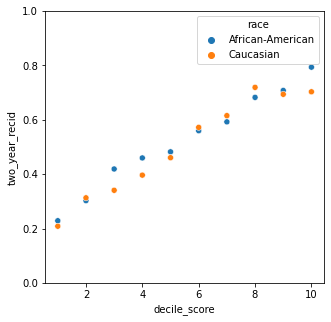

In [24]:
d = pd.DataFrame(df.groupby(['decile_score','race']).agg({'two_year_recid': 'mean'}))
d = d.reset_index()
im = sns.scatterplot(data=d, x='decile_score', y='two_year_recid', hue='race');
im.set(ylim=(0,1));

Now we look at the frequency with which defendants of each race are assigned each COMPAS score

,two_year_recid,is_med_or_high_risk,decile_score
race,,,
African-American,0.514340,0.588203,5.368777
Caucasian,0.393643,0.348003,3.735126


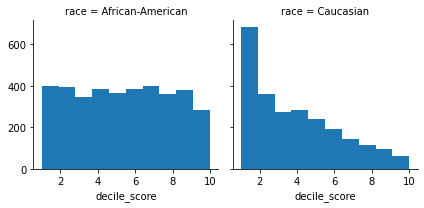

In [25]:
g = sns.FacetGrid(df, col="race", margin_titles=True);
g.map(plt.hist, "decile_score", bins=10);
df.groupby('race').agg({'two_year_recid': 'mean',  
                        'is_med_or_high_risk': 'mean', 
                        'decile_score': 'mean'})

We see that Caucasians are more likely to be assigned a low risk score.\
Now we try to fix this with different threshold.

In [26]:
black_threshold  = 6
df_black = df[df['race']=="African-American"].copy()
df_black['is_med_or_high_risk'] = (df_black['decile_score']>=black_threshold).astype(int)
[[tn , fp],[fn , tp]]  = confusion_matrix(df_black['two_year_recid'], df_black['is_med_or_high_risk'])
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Positive predictive value (Black): ", tp/(tp+fp))
print("Negative predictive value (Black): ", tn/(tn+fn))

False positive rate (Black)      :  0.34317548746518106
False negative rate (Black)      :  0.37243556023145713
Positive predictive value (Black):  0.6594803758982863
Negative predictive value (Black):  0.6248012718600954


In [27]:
white_threshold  = 4
df_white = df[df['race']=="Caucasian"].copy()
df_white['is_med_or_high_risk'] = (df_white['decile_score']>=white_threshold).astype(int)
[[tn , fp],[fn , tp]]  = confusion_matrix(df_white['two_year_recid'], df_white['is_med_or_high_risk'])
print("False positive rate (white)      : ", fp/(fp+tn))
print("False negative rate (white)      : ", fn/(fn+tp))
print("Positive predictive value (white): ", tp/(tp+fp))
print("Negative predictive value (white): ", tn/(tn+fn))

False positive rate (white)      :  0.35013440860215056
False negative rate (white)      :  0.36024844720496896
Positive predictive value (white):  0.5425812115891132
Negative predictive value (white):  0.7353612167300381


Now we make a relatively equal FPR and FNR for both groups